In [ ]:
!pip install gensim

In [ ]:
import pickle
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_file = datapath('/content/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.txt")

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-04-07 00:49:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-07 00:49:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-07 00:49:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -o glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open('/content/glove.6B.100d.txt', 'wb'))

In [ ]:
from typing import List

In [ ]:
MAX_TOKENS = 20000
MAX_DESCRIPTION_LENGTH = 300
EMBEDDING_DIM = 100

In [ ]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [ ]:
from keras.layers.preprocessing.text_vectorization import TextVectorization

# Textually Similar

In [ ]:
import pandas as pd
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
df_sim=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Eclipse_siamese_textually_similar_test_duplicates_preprocessed.csv')
df_sim = df_sim[df_sim.is_similar.astype('bool')].sample(300)
df_sim= df_sim.sample(300)

In [ ]:
df_sim = df_sim.drop(columns=['Unnamed: 0'])
df_sim

,description1,description2,is_similar
165,if i try to run tests for with tycho i g...,the package junit runner is missing in tyc...,1
179,from bug cgi id this should...,see some discussion about this in tycho bug ...,1
290,what steps will reproduce the problem se...,created attachment screenshot of pop up r...,1
508,created attachment eclipse error log the ...,created attachment error log hi using ...,1
487,entry org eclipse core resources ...,created attachment sample file to reproduc...,1
...,...,...,...
175,i just downloaded and installed the latest r...,the framework today detects the level of jav...,1
562,created attachment push blocked because no...,for example at the end of a rebase it wo...,1
578,viewing a directory on download eclipse org ...,show directory contents is not working any...,1
511,hi it s the first time i m trying to run a ...,created attachment added proposal for new ...,1


In [ ]:
FEATURES = ['description1', 'description2']

In [ ]:
import itertools

In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [df_sim.description1, df_sim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'eclipse', 'org', 'at']


In [ ]:
descr_vectorizer.vocabulary_size()

7439

In [ ]:
from typing import List, Dict, Tuple, Set

In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((descr_vectorizer.vocabulary_size(),EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (7439, 100)
Found 4066 words, missed 3373.


In [ ]:
descr_embedding_matrix.shape

(7439, 100)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.44308999,  0.14926   ,  0.16649   , ...,  0.044676  ,
         0.139     , -0.10406   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
X = descr_embedding_matrix

In [ ]:
pip install pyclustertend

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import scale
from pyclustertend import hopkins ## the hopkins test


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform

In [ ]:
import math
#Sample data must be preprocessed into dataframe or matrix form before given as the value of parameter "data".

In [ ]:
# hopkins(X, X.shape[0])

In [ ]:
# hopkins(scale(X),X.shape[0])

In [ ]:
# H=hopkins_statistic(X)
# print(H)

In [ ]:
X = descr_embedding_matrix

In [ ]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
     #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [ ]:
l = [] #list to hold values for each call
for i in range(300):
    H= hopkins_statistic(X)
    l.append(H)
#print average value:
print(H)
print(l)

0.8242329612870873
[0.821536937250178, 0.8247257160466986, 0.8321869753879805, 0.8205924922392963, 0.8228275059966401, 0.8319493340179465, 0.8197568260329811, 0.8266959627748639, 0.8307233181378648, 0.830353840871939, 0.8234534059091013, 0.8360457960937306, 0.81980629401282, 0.8325621824163312, 0.8294448666275573, 0.8232958559608463, 0.8114869628770548, 0.8274460026246482, 0.8315523137747065, 0.8286066628806753, 0.8328343409327884, 0.8295557694345745, 0.8288510456068165, 0.8296107050043547, 0.8235203101190318, 0.831386515815617, 0.8297361245368204, 0.8174351103137275, 0.8243347919683403, 0.8267170612345509, 0.8343777697489442, 0.8324960040080052, 0.8183692167134606, 0.8463270904857877, 0.8281055225978136, 0.8275133564189365, 0.8190943517776751, 0.8150670959447647, 0.8384906729714592, 0.8246101734568474, 0.8212880961207816, 0.8226531036199981, 0.8260390126261316, 0.8295673076017789, 0.8331211825806775, 0.825406295962348, 0.8236478219471626, 0.838465416483732, 0.8259055039617369, 0.83405

In [ ]:
df_sim_hopkin = pd.DataFrame(l)
print(df_sim_hopkin)

            0
0    0.821537
1    0.824726
2    0.832187
3    0.820592
4    0.822828
..        ...
295  0.833916
296  0.829482
297  0.823350
298  0.839471
299  0.824233

[300 rows x 1 columns]


# Textually Dissimilar

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
df_dissim = pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Eclipse_siamese_textually_dissimilar_test_duplicates_preprocessed.csv')
df_dissim = df_dissim[df_dissim.is_similar.astype('bool')].sample(300)
df_dissim

,Unnamed: 0,description1,description2,is_similar
86,94,i never change the default settings on the e...,we should add the option to skip the branch ...,1
275,302,created attachment project explorer wi...,created attachment find actions dark theme...,1
566,621,change added error condition if...,change it is a compile time error if an ass...,1
133,146,would be nice to have a linkfactory for crea...,similar to bug this one is for link sim...,1
238,260,created attachment wsl processes running...,created attachment eclipse jgit threaddump...,1
...,...,...,...,...
614,676,when gcc is installed memory head...,here s how the cool kids these days are doin...,1
235,257,we need to make sure that epl appears as...,jeremie has opened an issue on our behalf ...,1
368,405,new task context view actions ist to sma...,the context tab actions are not displaying r...,1
226,248,this bug was initially created as a clon...,build identifier provided that cvs is ava...,1


In [ ]:
df_dissim = df_dissim.drop(columns=['Unnamed: 0'])
df_dissim

,description1,description2,is_similar
86,i never change the default settings on the e...,we should add the option to skip the branch ...,1
275,created attachment project explorer wi...,created attachment find actions dark theme...,1
566,change added error condition if...,change it is a compile time error if an ass...,1
133,would be nice to have a linkfactory for crea...,similar to bug this one is for link sim...,1
238,created attachment wsl processes running...,created attachment eclipse jgit threaddump...,1
...,...,...,...
614,when gcc is installed memory head...,here s how the cool kids these days are doin...,1
235,we need to make sure that epl appears as...,jeremie has opened an issue on our behalf ...,1
368,new task context view actions ist to sma...,the context tab actions are not displaying r...,1
226,this bug was initially created as a clon...,build identifier provided that cvs is ava...,1


In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [df_dissim.description1, df_dissim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'the', 'eclipse', 'in']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((descr_vectorizer.vocabulary_size(), EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix1 = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (5539, 100)
Found 3733 words, missed 1806.


In [ ]:
descr_embedding_matrix1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.31790999, -0.32554999, -0.31496   , ...,  0.53825998,
        -0.30695999, -0.85655999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.69509   , -0.40583   ,  0.49144   , ..., -0.022975  ,
         0.79710001,  0.041716  ]])

In [ ]:
X1 = descr_embedding_matrix1

In [ ]:
#hopkins(scale(X1),X1.shape[0])

In [ ]:
#hopkins(X1, X1.shape[0])

In [ ]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X1):
    
     #convert dataframe to a numpy array
    sample_size = int(X1.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X1_uniform_random_sample = uniform(X1.min(axis=0), X1.max(axis=0) ,(sample_size , X1.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X1.shape[0], 1), sample_size)
    X1_sample = X1[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X1)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X1_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X1_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [ ]:
l1 = [] #list to hold values for each call
for i in range(300):
    H1=hopkins_statistic(X1)
    l1.append(H1)
#print average value:
print(H1)
print(l1)

0.797272046213317
[0.7828455892774291, 0.8001048344071238, 0.7956174613657607, 0.8025530539864181, 0.7878236433930063, 0.7963584668522783, 0.7956096098156912, 0.8005439636702608, 0.795267843884561, 0.8033422668583561, 0.8092943755958896, 0.7909236697122682, 0.8003849559905865, 0.8005526462548415, 0.7892054444408405, 0.803040404571761, 0.7944224600996687, 0.797987708618008, 0.8003654005245321, 0.8077464392614133, 0.7940914085327188, 0.7898920576734073, 0.7922381940156401, 0.8059713777297597, 0.7961834345271701, 0.7913210021215266, 0.7962220808074284, 0.7946797310312163, 0.80520692884431, 0.7857656238601289, 0.7997624456315413, 0.798022255854832, 0.7989077704395608, 0.79387947936926, 0.8018722335929368, 0.7881389541900847, 0.7937803963166741, 0.8036297382587497, 0.7905563025783218, 0.80170046436212, 0.7983061878896013, 0.7950510666569582, 0.8003132000181629, 0.7998369756354982, 0.7977727716523347, 0.79371647856967, 0.7999752508924248, 0.7953826899072896, 0.7895259788818672, 0.80022262132

In [ ]:
# print in new line
print(l1, sep = "\n")

[0.7828455892774291, 0.8001048344071238, 0.7956174613657607, 0.8025530539864181, 0.7878236433930063, 0.7963584668522783, 0.7956096098156912, 0.8005439636702608, 0.795267843884561, 0.8033422668583561, 0.8092943755958896, 0.7909236697122682, 0.8003849559905865, 0.8005526462548415, 0.7892054444408405, 0.803040404571761, 0.7944224600996687, 0.797987708618008, 0.8003654005245321, 0.8077464392614133, 0.7940914085327188, 0.7898920576734073, 0.7922381940156401, 0.8059713777297597, 0.7961834345271701, 0.7913210021215266, 0.7962220808074284, 0.7946797310312163, 0.80520692884431, 0.7857656238601289, 0.7997624456315413, 0.798022255854832, 0.7989077704395608, 0.79387947936926, 0.8018722335929368, 0.7881389541900847, 0.7937803963166741, 0.8036297382587497, 0.7905563025783218, 0.80170046436212, 0.7983061878896013, 0.7950510666569582, 0.8003132000181629, 0.7998369756354982, 0.7977727716523347, 0.79371647856967, 0.7999752508924248, 0.7953826899072896, 0.7895259788818672, 0.8002226213227233, 0.793166723

In [ ]:
print('\n'.join(map(str, l1)))

0.7828455892774291
0.8001048344071238
0.7956174613657607
0.8025530539864181
0.7878236433930063
0.7963584668522783
0.7956096098156912
0.8005439636702608
0.795267843884561
0.8033422668583561
0.8092943755958896
0.7909236697122682
0.8003849559905865
0.8005526462548415
0.7892054444408405
0.803040404571761
0.7944224600996687
0.797987708618008
0.8003654005245321
0.8077464392614133
0.7940914085327188
0.7898920576734073
0.7922381940156401
0.8059713777297597
0.7961834345271701
0.7913210021215266
0.7962220808074284
0.7946797310312163
0.80520692884431
0.7857656238601289
0.7997624456315413
0.798022255854832
0.7989077704395608
0.79387947936926
0.8018722335929368
0.7881389541900847
0.7937803963166741
0.8036297382587497
0.7905563025783218
0.80170046436212
0.7983061878896013
0.7950510666569582
0.8003132000181629
0.7998369756354982
0.7977727716523347
0.79371647856967
0.7999752508924248
0.7953826899072896
0.7895259788818672
0.8002226213227233
0.7931667239612163
0.7996556609277186
0.8045527871049889
0.787

In [ ]:
len(l1)

300

In [ ]:
df_dissim_hopkin = pd.DataFrame(l1)
print(df_dissim_hopkin)

            0
0    0.782846
1    0.800105
2    0.795617
3    0.802553
4    0.787824
..        ...
295  0.788551
296  0.798542
297  0.801477
298  0.782454
299  0.797272

[300 rows x 1 columns]


In [ ]:
df_dissim_hopkin.shape

(300, 1)

In [ ]:
import seaborn as sns

## Box plot using hopkin test value for each pair

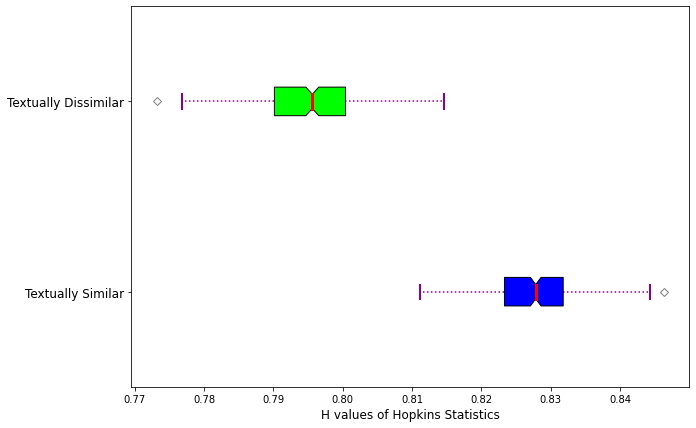

<Figure size 432x288 with 0 Axes>

In [ ]:

# Import libraries
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = l #tex_sim
data_2 = l1 #tex_dissim

data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
plt.xlabel('H values of Hopkins Statistics', fontsize = 12)
ax.set_yticklabels(['Textually Similar', 'Textually Dissimilar'], fontsize = 12)
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

fig = plt.figure()
fig.savefig('hopkin_eclipse.jpg')

In [ ]:
#!pip install PyNonpar

In [ ]:
#pip install scipy pandas pingouin

In [ ]:
## Significance test
import pandas as pd
import numpy as np
from scipy import stats
from numpy.random import seed
from scipy.stats import kstest
from scipy.stats import ks_2samp
np.random.seed(0)
rng = np.random.default_rng()
import pandas as pd
import numpy as np
from scipy import stats
from numpy.random import seed
from scipy.stats import kstest
from scipy.stats import ks_2samp
np.random.seed(0)
rng = np.random.default_rng()
from sklearn.metrics.pairwise import cosine_similarity
import statistics
from datetime import datetime
from scipy.stats import skew
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
import cv2
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import PyNonpar
from PyNonpar.twosample import wilcoxon_mann_whitney_test

In [ ]:
hopkin_sim = l
hopkin_sim

In [ ]:
hopkin_dissim= l1
hopkin_dissim

In [ ]:
print ("eclipse_hopkin_sim_dist:", stats.kstest(hopkin_sim, 'norm')) # Not normal dist

In [ ]:
print ("eclipse_hopkin_dissim_dist:", stats.kstest(hopkin_dissim, 'norm')) # Not normal dist

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
PyNonpar.twosample.wilcoxon_mann_whitney_test(hopkin_sim, hopkin_dissim, method= "asymptotic")

In [ ]:
import math
z = abs(-21.13620029857694)
n = 5
r = z/math.sqrt(n)
print(r) #large effect